# Car Classification Model Training

This notebook trains a Hybrid ResNet-ViT model for Indonesian car classification using the collected dataset. The model combines ResNet-50 as a feature extractor with a Vision Transformer for classification.

## Dataset Structure
- **Classes**: 8 Indonesian car types (hatchback, mpv, offroad, pickup, sedan, suv, truck, van)
- **Architecture**: Hybrid ResNet-ViT combining CNN and Transformer
- **Training Strategy**: Transfer learning with data augmentation
- **Class Imbalance**: Handled using weighted loss function for better minority class performance

## Training Process
1. Dataset exploration and class imbalance analysis
2. Model training with weighted loss and comprehensive tracking
3. Performance analysis with detailed charts and metrics
4. Model evaluation with per-class analysis and confusion matrix
5. Training insights and recommendations for optimization

In [1]:
!rm -rf /kaggle/working
!git clone https://github.com/luthfiarifin/Hybrid-RViT-Car-Retrieval.git code
!mv code/* .
!ls

rm: cannot remove '/kaggle/working': Device or resource busy
Cloning into 'code'...
remote: Enumerating objects: 29509, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 29509 (delta 8), reused 13 (delta 3), pack-reused 29488 (from 1)
Receiving objects: 100% (29509/29509), 794.70 MiB | 48.75 MiB/s, done.
Resolving deltas: 100% (306/306), done.
Updating files: 100% (17920/17920), done.
1_run_scraper_into_dataset.ipynb	code		 models
2_train_the_classification_model.ipynb	data_processing


In [2]:
# Import required libraries
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Set style for plots
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA memory: 15.9 GB


2025-06-22 19:39:33.495846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750621173.695873      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750621173.749781      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===
Using device: cuda
Logging to TensorBoard: logs/train_classification/run_1750621189


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


Using weighted CrossEntropyLoss with weights: tensor([0.8700, 1.2378, 0.6752, 1.1956, 0.8212, 0.6525, 2.8079, 1.6157],
       device='cuda:0')

📊 Class Distribution Analysis:
Class        Count    Percentage Imbalance Ratio
--------------------------------------------------
city_car     2056     14.4      % 1.33           x
hatchback    1445     10.1      % 1.90           x
mpv          2649     18.5      % 1.03           x
pickup       1496     10.5      % 1.83           x
sedan        2178     15.2      % 1.26           x
suv          2741     19.2      % 1.00           x
truck        637      4.5       % 4.30           x
van          1107     7.7       % 2.48           x

📈 Imbalance Factor: 4.30x (Most frequent / Least frequent)
⚠️  Moderate imbalance detected. Weighted loss recommended.
Trainer initialized successfully!
Training samples: 14309
Validation samples: 1789
Number of batches per epoch: 224
Class names: ['city_car', 'hatchback', 'mpv', 'pickup', 'sedan', 'suv', 'truck', 

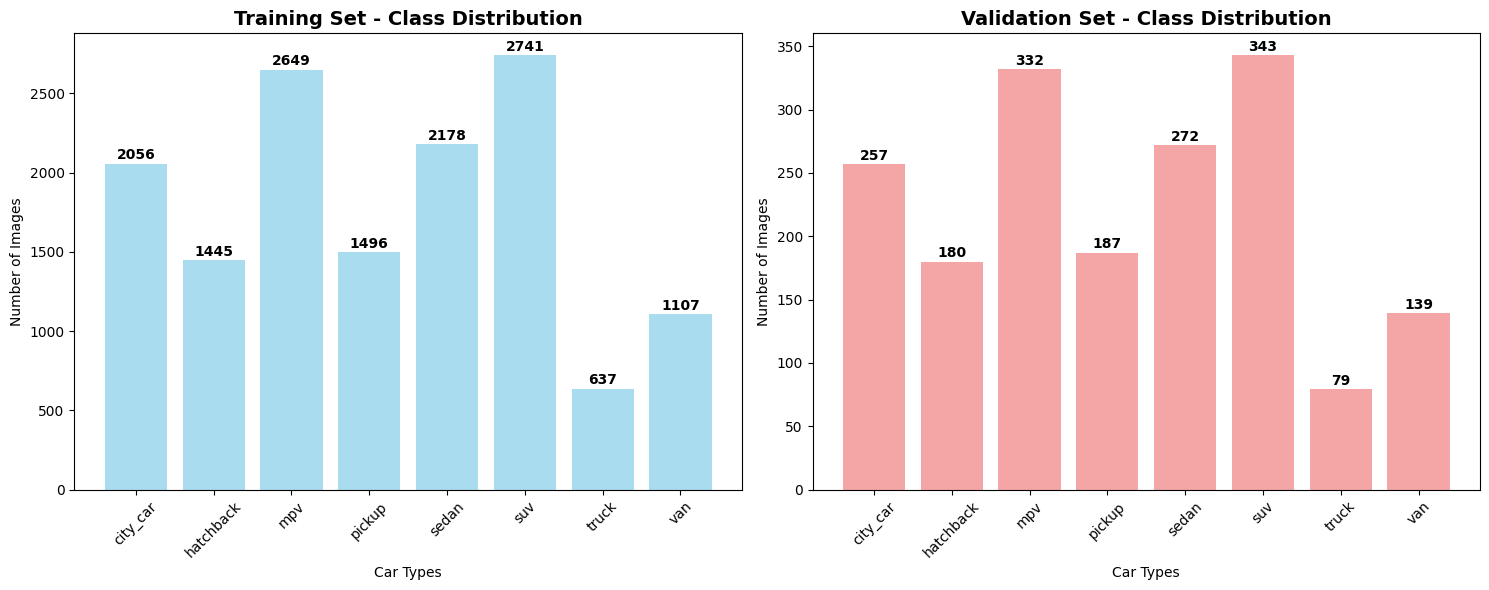


=== Dataset Summary ===
    Class  Training  Validation  Total  Train_Ratio
 city_car      2056         257   2313        0.889
hatchback      1445         180   1625        0.889
      mpv      2649         332   2981        0.889
   pickup      1496         187   1683        0.889
    sedan      2178         272   2450        0.889
      suv      2741         343   3084        0.889
    truck       637          79    716        0.890
      van      1107         139   1246        0.888


In [3]:
# Training configuration

from models.classification.train_classification import CarClassifierTrainer

CONFIG = {
    "train_dir": "data_processing/data/dataset/train",
    "val_dir": "data_processing/data/dataset/val",
    "num_classes": 8,
    "embed_dim": 768,
    "num_heads": 12,
    "num_layers": 6,
    "dropout": 0.1,
    "learning_rate": 1e-4,
    "batch_size": 64,
    "num_epochs": 25,
    "result_path": f'models/results/carvit_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth',
    "use_weighted_loss": True,
    "use_class_balancing": False,
    "num_workers": 8,
    "early_stopping_patience": 7,
    "early_stopping_delta": 0.001,
    "early_stopping_verbose": True,
}

# Initialize the trainer with class imbalance handling and early stopping
print("\n=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===")
trainer = CarClassifierTrainer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
    num_classes=CONFIG["num_classes"],
    embed_dim=CONFIG["embed_dim"],
    num_heads=CONFIG["num_heads"],
    num_layers=CONFIG["num_layers"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    batch_size=CONFIG["batch_size"],
    num_epochs=CONFIG["num_epochs"],
    result_path=CONFIG["result_path"],
    use_weighted_loss=CONFIG["use_weighted_loss"],
    use_class_balancing=CONFIG["use_class_balancing"],
    num_workers=CONFIG["num_workers"],
    early_stopping_patience=CONFIG["early_stopping_patience"],
    early_stopping_delta=CONFIG["early_stopping_delta"],
    early_stopping_verbose=CONFIG["early_stopping_verbose"],
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(trainer.train_dataset)}")
print(f"Validation samples: {len(trainer.val_dataset)}")
print(f"Number of batches per epoch: {len(trainer.train_loader)}")
print(f"Class names: {trainer.train_dataset.classes}")

from models.classification.training_report import TrainingReport

# Create a training report instance
report = TrainingReport(trainer, CONFIG, None)

# Generate and summary report
report.dataset_summary_report()

In [4]:
# Start training with detailed tracking
start_time = time.time()

# Execute training
training_results = trainer.train()

# Print training results
total_time = time.time() - start_time
print(f"\n=== Training Completed in {total_time:.2f} seconds ===")

Starting training with detailed tracking and early stopping...
Early Stopping - Patience: 7, Delta: 0.001
Model parameters: 143,116,360
Trainable parameters: 143,116,360

Epoch 1/25


100%|██████████| 224/224 [02:29<00:00,  1.50it/s, loss=1.36] 


Validation accuracy: 68.98%
Validation loss: 0.8304
Time: 157.40s | LR: 1.00e-04
🎉 New best accuracy: 68.98%
Validation loss decreased (inf --> 0.830362).  Saving model ...

Epoch 2/25


100%|██████████| 224/224 [02:29<00:00,  1.50it/s, loss=0.881]


Validation accuracy: 77.98%
Validation loss: 0.6225
Time: 157.80s | LR: 1.00e-04
🎉 New best accuracy: 77.98%
Validation loss decreased (0.830362 --> 0.622499).  Saving model ...

Epoch 3/25


100%|██████████| 224/224 [02:27<00:00,  1.51it/s, loss=0.375]


Validation accuracy: 80.88%
Validation loss: 0.5706
Time: 155.89s | LR: 1.00e-04
🎉 New best accuracy: 80.88%
Validation loss decreased (0.622499 --> 0.570619).  Saving model ...

Epoch 4/25


100%|██████████| 224/224 [02:27<00:00,  1.52it/s, loss=0.552]


Validation accuracy: 82.95%
Validation loss: 0.4888
Time: 155.03s | LR: 1.00e-04
🎉 New best accuracy: 82.95%
Validation loss decreased (0.570619 --> 0.488841).  Saving model ...

Epoch 5/25


100%|██████████| 224/224 [02:26<00:00,  1.52it/s, loss=0.774]


Validation accuracy: 84.24%
Validation loss: 0.4824
Time: 154.78s | LR: 1.00e-04
🎉 New best accuracy: 84.24%
Validation loss decreased (0.488841 --> 0.482443).  Saving model ...

Epoch 6/25


100%|██████████| 224/224 [02:26<00:00,  1.53it/s, loss=0.547]


Validation accuracy: 85.47%
Validation loss: 0.5280
Time: 154.77s | LR: 1.00e-04
🎉 New best accuracy: 85.47%
EarlyStopping counter: 1 out of 7

Epoch 7/25


100%|██████████| 224/224 [02:26<00:00,  1.53it/s, loss=0.305] 


Validation accuracy: 85.75%
Validation loss: 0.4539
Time: 154.36s | LR: 1.00e-04
🎉 New best accuracy: 85.75%
Validation loss decreased (0.482443 --> 0.453852).  Saving model ...

Epoch 8/25


100%|██████████| 224/224 [02:26<00:00,  1.53it/s, loss=0.3]   


Validation accuracy: 85.47%
Validation loss: 0.4713
Time: 154.39s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 9/25


100%|██████████| 224/224 [02:25<00:00,  1.54it/s, loss=0.364]


Validation accuracy: 86.53%
Validation loss: 0.4758
Time: 153.27s | LR: 1.00e-04
🎉 New best accuracy: 86.53%
EarlyStopping counter: 2 out of 7

Epoch 10/25


100%|██████████| 224/224 [02:25<00:00,  1.53it/s, loss=0.238] 


Validation accuracy: 87.87%
Validation loss: 0.4658
Time: 153.82s | LR: 1.00e-04
🎉 New best accuracy: 87.87%
EarlyStopping counter: 3 out of 7

Epoch 11/25


100%|██████████| 224/224 [02:25<00:00,  1.54it/s, loss=0.145] 


Validation accuracy: 87.20%
Validation loss: 0.4152
Time: 153.74s | LR: 1.00e-04
Validation loss decreased (0.453852 --> 0.415195).  Saving model ...

Epoch 12/25


100%|██████████| 224/224 [02:25<00:00,  1.54it/s, loss=0.321] 


Validation accuracy: 86.86%
Validation loss: 0.4582
Time: 153.93s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 13/25


100%|██████████| 224/224 [02:26<00:00,  1.53it/s, loss=0.228] 


Validation accuracy: 87.59%
Validation loss: 0.4482
Time: 154.50s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 14/25


100%|██████████| 224/224 [02:27<00:00,  1.52it/s, loss=0.367] 


Validation accuracy: 87.98%
Validation loss: 0.4696
Time: 155.21s | LR: 1.00e-04
🎉 New best accuracy: 87.98%
EarlyStopping counter: 3 out of 7

Epoch 15/25


100%|██████████| 224/224 [02:27<00:00,  1.52it/s, loss=0.252] 


Validation accuracy: 87.53%
Validation loss: 0.5193
Time: 155.15s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 16/25


100%|██████████| 224/224 [02:26<00:00,  1.53it/s, loss=0.538] 


Validation accuracy: 87.48%
Validation loss: 0.4771
Time: 154.78s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 17/25


100%|██████████| 224/224 [02:26<00:00,  1.52it/s, loss=0.556] 


Validation accuracy: 88.04%
Validation loss: 0.4174
Time: 154.79s | LR: 1.00e-04
🎉 New best accuracy: 88.04%
EarlyStopping counter: 6 out of 7

Epoch 18/25


100%|██████████| 224/224 [02:26<00:00,  1.53it/s, loss=0.159] 


Validation accuracy: 88.04%
Validation loss: 0.4624
Time: 154.72s | LR: 1.00e-04
EarlyStopping counter: 7 out of 7

🛑 Early stopping triggered at epoch 18
Best validation loss: 0.415195

Training completed!
Training stopped early at epoch 18 due to no improvement in validation loss
Best validation accuracy: 88.04%
Loading best model with validation loss: 0.415195
Best accuracy model saved to models/results/carvit_model_20250622_193949_best_acc.pth

=== Training Completed in 2799.75 seconds ===


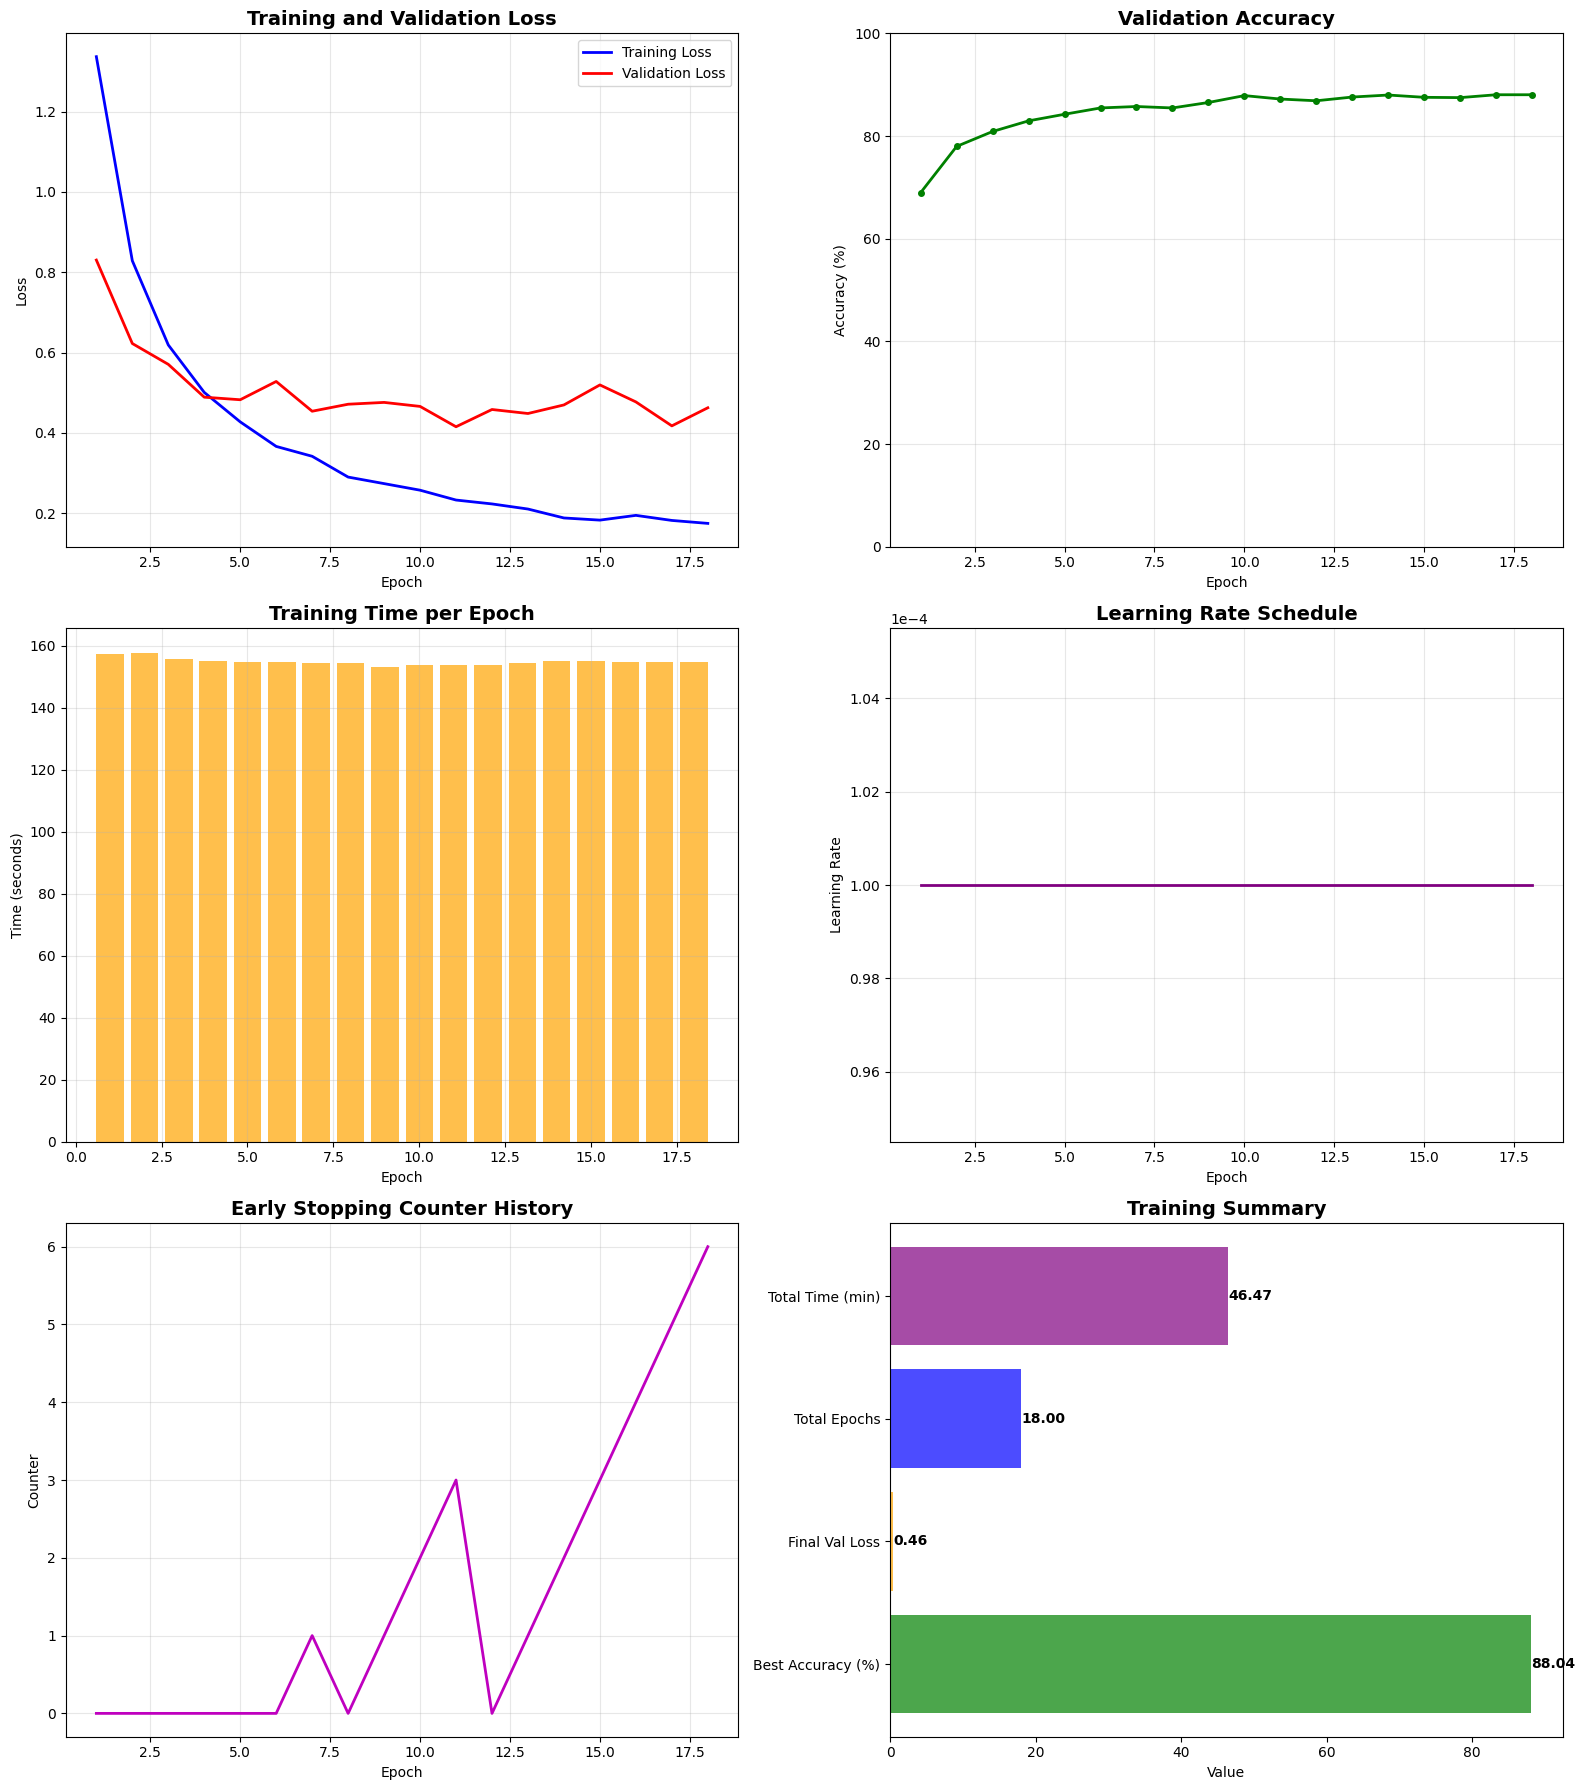


🛑 Early Stopping Analysis:
Early stopping triggered at epoch 18/25.
Epochs saved: 7
Time saved: ~18.1 minutes
Efficiency gain: 28.0%

📈 Detailed Training Statistics:
- Loss Reduction: 1.3369 → 0.1745 (86.9% improvement)
- Best Accuracy: 88.04% (Epoch 17)
- Total Training Time: 46.47 minutes
- Average Time per Epoch: 154.91s
- Fastest Epoch: 153.27s
- Slowest Epoch: 157.80s
- Early Stopping Counter History: [0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 6]

📋 Training Metrics Table (Last 5 Epochs):
 Epoch  Train_Loss  Val_Loss  Val_Accuracy  Epoch_Time  Learning_Rate  ES_Counter
    14      0.1880    0.4696         87.98      155.21         0.0001           2
    15      0.1827    0.5193         87.53      155.15         0.0001           3
    16      0.1945    0.4771         87.48      154.78         0.0001           4
    17      0.1819    0.4174         88.04      154.79         0.0001           5
    18      0.1745    0.4624         88.04      154.72         0.0001           6

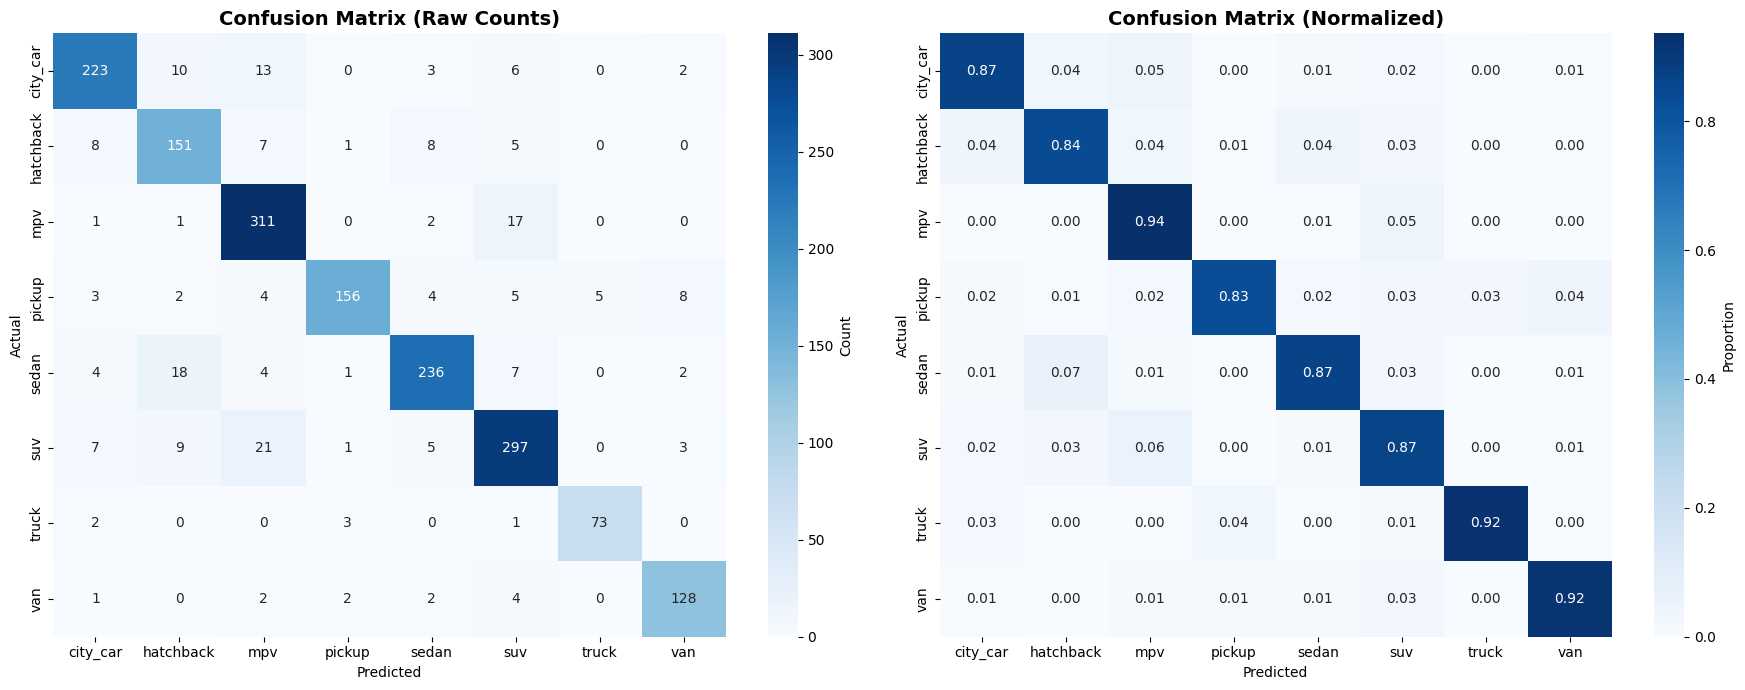


📊 Detailed Classification Report:
              precision    recall  f1-score   support

    city_car     0.8956    0.8677    0.8814       257
   hatchback     0.7906    0.8389    0.8140       180
         mpv     0.8591    0.9367    0.8963       332
      pickup     0.9512    0.8342    0.8889       187
       sedan     0.9077    0.8676    0.8872       272
         suv     0.8684    0.8659    0.8672       343
       truck     0.9359    0.9241    0.9299        79
         van     0.8951    0.9209    0.9078       139

    accuracy                         0.8804      1789
   macro avg     0.8880    0.8820    0.8841      1789
weighted avg     0.8824    0.8804    0.8805      1789


⚖️ Class Imbalance Impact Analysis:

📈 Class Group Performance:
Minority Classes (4): ['hatchback', 'pickup', 'truck', 'van']
Average Accuracy: 87.95%
Majority Classes (4): ['city_car', 'mpv', 'sedan', 'suv']
Average Accuracy: 88.45%
Performance Gap: 0.50% (Majority better)


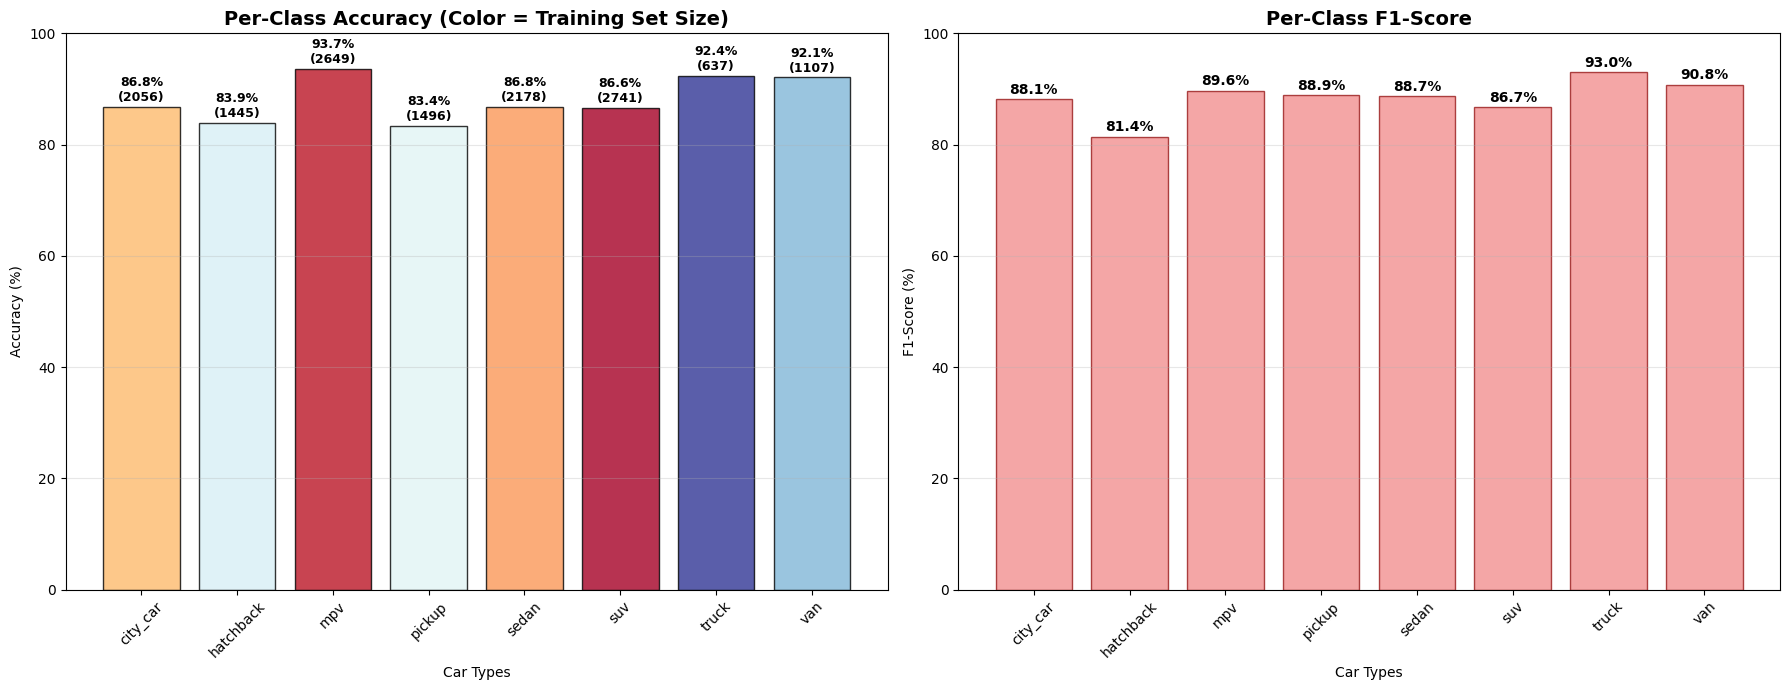


🛑 Early stopping summary saved to: models/classification/reports/early_stopping_summary_20250622_203226.json

💾 Training history saved to: models/classification/reports/training_history_20250622_203226.csv
📊 Class performance saved to: models/classification/reports/class_performance_20250622_203226.csv
🎯 Best model saved to: models/results/carvit_model_20250622_193949.pth
🏆 Best accuracy model saved to: models/results/carvit_model_20250622_193949_best_acc.pth

🎉 Training Analysis Complete!
🎯 Final Summary:
- Training completed in 18 epochs (planned: 25)
- Best validation accuracy: 88.04%
- Early stopping: Activated
- Total training time: 46.47 minutes
- Time saved by early stopping: 18.1 minutes
- Class imbalance: Moderate (ratio: 4.30x)
- Model saved with best validation loss: 0.415195


In [6]:
report = TrainingReport(trainer, CONFIG, training_results)

# Generate the full report
report.full_report()